<a href="https://colab.research.google.com/github/anthonymelson/portfolio/blob/master/Bayesian_Estimation_of_Difference_in_Success_Rate_Between_Two_Groups_on_Binary_Task_Using_Pymc3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Estimation of Difference in Success Rate Between Two Groups on Binary Task Using Pymc3

This notebook is meant to be a gentle intro to Bayesian Estimation.  The goal is not to promote it as superior to frequentist hypothesis testing, but rather to highlight some of its appealing characteristics and show how it can be implemented in Pymc3.

## Problem Discussion and Model Specification

In the following, a model will be specified as two Bernoulli Random Variables (one for each arm of the experiment) with Normal Distributions as priors for their probability parameter (p).  Next, the posterior distributions (probability of probabilities of success) for each arm will be inferred using MCMC, and the difference between the two resultant distributions will be taken to get Delta_P (probability of a range differences in probability of success between the two groups).

It should be noted that Normal Distributions will be used as priors instead of the Beta Distribution (which is the conjugate prior for Bernoulli Distribution) because it better represented the prior beliefs of the author.  They reasoned that even loaded coins are not likely to be too far from center since thier general shape (and the physics that govern that shape) would not allow for extreme bias.  Additional wieght was given to the idea that coins that are too loaded or have the same symbol on each side wouldn't serve the function of deception that thier designers presumably intend them to serve.  Both prior beliefs were easier to encode into the std parameter of a Normal Distribution than any of the parameters in the Beta Distribution.

Bayesian Estimation is used in many areas where understanding a range of likely outcomes is can improve decision-making under uncertainty (clinical trials, marketing promotions...).  Also worth mentioning, when contrasted with frequentist approaches to estimating group differences (i.e. null hypothesis testing), benefits *can* include: 
* clearer output (distribution of probabilities, instead of p-vals and confidence intervals)
* increased flexibility (small N, uneven groups, unequal var...)
* encoding/utilization of prior understanding (domain expertise, previous research...) into the prior (conjugate) distributions.

# Import Packages

In [2]:
import arviz as az
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create Data

The code below simulates the flipping of two coins with potentially unequal wieghts and sample sizes.

In [3]:
a = np.random.choice(a=[1,0],size=25,p=[0.55,0.45])
b = np.random.choice(a=[1,0],size=45,p=[0.65,0.35])

# Model Initialization and Considerations

The Normal Distributions are not biased to incorporate prior knowledge of the specific coins (i.e. mu = 0.5, fair coin assumed).  Rather they encode the increase likelihood of a loaded coin to be closer to center than to the edge of the probability space (0 - 1).  

To capture this, the mean was set to zero and standard deviation was set to 0.1, meaning the edges of the proability space (0,1) are several standard deviations out from the mean.  Though it is possible for a coin-shaped object to be loaded enough to be improbable in the selected distribution, the authors think the likelihood is negligable. 

In [4]:
# convert input data to numpy arrays
a = np.asarray(a)
b = np.asarray(b)
with pm.Model() as model:

  # Create priors for bernoulli distributions
  mu_a, mu_b, sigma_a, sigma_b = 0.5, 0.5, 0.15, 0.15

  p_a = pm.Normal('p_a', mu=mu_a, sigma=sigma_a)
  p_b = pm.Normal('p_b', mu=mu_b, sigma=sigma_b)

  # Bernoulli random variables with priors AND observed data for both groups
  a_obs = pm.Bernoulli('a_obs', p=p_a, observed=a)
  b_obs = pm.Bernoulli('b_obs', p=p_b, observed=b)

  # Take difference between posteriors to get Delta_p
  delta = pm.Deterministic('delta', p_a - p_b)

  # Sample from the previously defined model
  trace = pm.sample(1000, return_inferencedata=True)

  # Use sample to estimate posterior distributions for both experimental arms
  a_posterior = trace.posterior['p_a'].values
  b_posterior = trace.posterior['p_b'].values

  delta_posterior = trace.posterior['delta'].values

  # Find probability that the success probability is higher in arm a than b
  prob_a_over_b = (a_posterior[0] > b_posterior[0]).mean()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_b, p_a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


# Results Summary and Visualization

## Summary of Model Variables & Probability of Difference

Below the mean, standard deviation, and credible intervals of the normal posteriors (for the parameters p in the two Bernoulli Distributions) are shown along with thier deltas (focus of the test).

Next, the probability of a difference in success probabilities is shown for the cases where a > b and b > a.

In [5]:
az.summary(trace, kind='stats')

,mean,sd,hdi_3%,hdi_97%
p_a,0.537,0.080,0.386,0.685
p_b,0.686,0.064,0.573,0.809
delta,-0.149,0.101,-0.334,0.028


In [6]:
print('P(P_success(a) > P_success(b)): ', prob_a_over_b)
print('P(P_success(b) > P_success(a)): ', 1 - prob_a_over_b)

P(P_success(a) > P_success(b)):  0.092
P(P_success(b) > P_success(a)):  0.908


# View Posterior Distributions

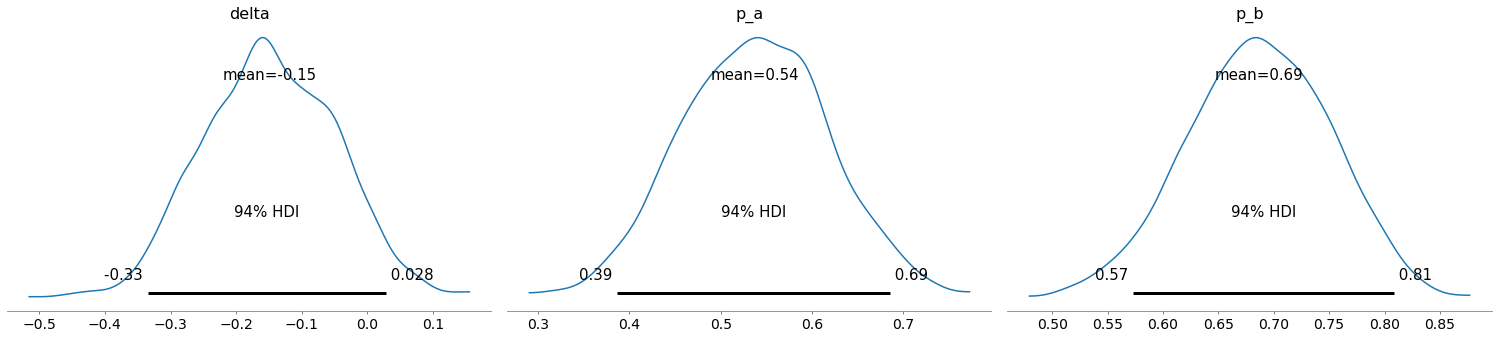

In [7]:
az.plot_posterior(trace, ['delta', 'p_a', 'p_b'])
plt.show()

## A Second View of Posteriors

These visualizations better reveal the overlap and difference between the two posteriors.  Additionally, plotting the two together gives a clearer read of thier comparative variability, which is interpretable as certainty/reliability.

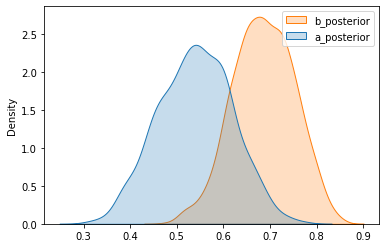

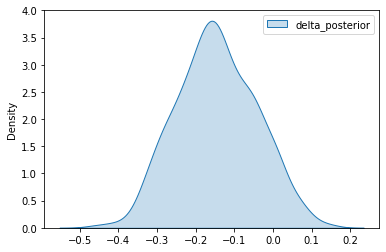

In [9]:
kde = sns.kdeplot(data=[a_posterior[0],b_posterior[0]], fill=True)
kde.legend(labels=['b_posterior','a_posterior'])
plt.show()
delta_kde = sns.kdeplot(data=delta_posterior[0], fill=True)
delta_kde.legend(labels=['delta_posterior'])
#delta_kde.vlines([delta_post.mean()], ymin=0,ymax=10)
plt.show()